Gammapy Event Sampling Prototype
===========

Authors: Fabio Pintore and Axel Donath

This notebook sketches a prototype for event sampling with Gammapy.


Here is list of TODOs:

- debug why the total number events changes when re-executing `MapEventSample.npred_total`
- add missing docstrings and make them complete, examples of the dosctring format are in the Gammapy code base (DONE)
- add sampling of phi angle for PDF (DONE)
- compute the reconstructed positions of the events (DONE)

- add application of energy dispersion (DONE)
- compute reconstructed energy of the events (DONE)



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack

In [2]:
from gammapy.cube import MapDataset

In [3]:
from gammapy.utils.random import get_random_state
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import MapEvaluator
from gammapy.cube import MapDataset

from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord,Angle

In [4]:
from gammapy.image.models import SkyGaussian
from gammapy.spectrum.models import PowerLaw
from gammapy.cube.models import SkyModel
from gammapy.irf import PSF3D, EnergyDependentMultiGaussPSF, EnergyDispersion2D, Background3D
from gammapy.utils.energy import EnergyBounds

In [5]:
from gammapy.cube import make_psf_map, make_map_background_irf, make_edisp_map

In [6]:
from gammapy.time.models import LightCurveTableModel as LC

### Inverse CDF Sampler

In [7]:
class InverseCDFSampler:
    """Inverse CDF sampler.
    
    Parameters
    ----------
    pdf : `~`gammapy.maps.Map`
      predicted source counts  
    
    """
    def __init__(self, pdf, axis=None, random_state=0):
        """Determines a set of random numbers and calculate the cumulative distribution function"""
        self.random_state = get_random_state(random_state) 
        self.axis = axis       
        
        if axis is not None:
            self.cdf = np.cumsum(pdf, axis=self.axis)
            self.cdf /= self.cdf[:, [-1]]
        else:
            self.pdf_shape = pdf.shape  #gives the shape of the PDF array

            pdf = pdf.ravel() / pdf.sum()  #flattens the array along one axis
            self.sortindex = np.argsort(pdf, axis=None) #sorting of the elements and giving the indexes

            self.pdf = pdf[self.sortindex]  #sort the pdf array
            self.cdf = np.cumsum(self.pdf)  #evaluate the cumulative sum of the PDF array
        
    def sample_axis(self):
        """Sample along a given axis.
        """
        choice = self.random_state.uniform(high=1, size=len(self.cdf))
        
        #find the indices corresponding to this point on the CDF
        index = np.argmin(np.abs(choice.reshape(-1, 1) - self.cdf), axis=self.axis)
        
        return index + self.random_state.uniform(low=-0.5, high=0.5,
                                                 size=len(self.cdf))
    def sample(self, size):
        """Draw sample from the given PDF.
        
        Parameters
        ----------
        size : int
            Number of samples to draw.
            
        Returns
        -------
        index : tuple of `~numpy.ndarray`
            Coordinates of the drawn sample      
        """
        #pick numbers which are uniformly random over the cumulative distribution function
        choice = self.random_state.uniform(high=1, size=size)

        #find the indices corresponding to this point on the CDF
        index = np.searchsorted(self.cdf, choice)
        index = self.sortindex[index]

        # map back to multi-dimensional indexing
        index = np.unravel_index(index, self.pdf_shape) 
        index = np.vstack(index)

        index = index + self.random_state.uniform(low=-0.5, high=0.5,
                                      size=index.shape)
        return index

 ### MapEventSampler 

In [14]:
class MapEventSampler:
    """Map event sampler
    
    Parameters
    ----------
    
    npred_map : `~gammapy.maps.Map`
        Predicted number of counts map.
    background_map : `~gammapy.cube.make_map_background_irf`
        IRF background map.
    random_state : seed for the random number sampler    
    exposure: livetime in hours, e.g. `10 * u.hour`    
    lc : `~gammapy.time.models.LightCurveTableModel`
        input light-curve of the source, given with columns labelled as "time" and "normalization" (arbitrary units)
        
    """
    
#     def __init__(self, npred_map, psf_map=None, edisp_map=None, background_map=None,
#                  random_state=0, exposure = 1.0 * u.hour, lc = None):
    def __init__(self, npred_map, background_map=None,
                 random_state=0, exposure = None, lc = None):
        self.random_state = get_random_state(random_state)
        self.npred_map = npred_map
#         self.psf_map = psf_map
#         self.edisp_map = edisp_map
        self.background_map = background_map
        self.exposure = exposure
        self.lc = lc

    def npred_total(self):
        """ Calculate the total number of the simulated predicted events """       
        #return self.random_state.poisson(self.npred_map.data.sum())
        return self.random_state.poisson(np.sum(self.npred_map.data))

    def nbkgpred_total(self):
        """ Calculate the total number of the simulated background events """       
        #return self.random_state.poisson(self.npred_map.data.sum())
        return self.random_state.poisson(np.sum(self.background_map.data))
        
    def sample_npred(self):
        """ Calculate energy and coordinates of the simulated source events """       
        n_events = self.npred_total()
        
        cdf_sampler = InverseCDFSampler(self.npred_map.data, random_state=self.random_state)
        
        pix_coords = cdf_sampler.sample(n_events)
        coords = self.npred_map.geom.pix_to_coord(pix_coords[::-1])
        
        normalization = self.lc.table['normalization'].data  
        
        if self.lc is not None:
            time_sampler = InverseCDFSampler(normalization,random_state=self.random_state)
            ToA = time_sampler.sample(n_events)
        
        else:
            ToA = self.random_state.uniform(high=self.exposure.to('s').value, size=n_events)

        events = Table()
        events['lon_true'] = coords[0] * u.deg
        events['lat_true'] = coords[1] * u.deg
        events['e_true'] = coords[2] * u.TeV
        events['time'] = ToA[0] * u.s
        return events

    def sample_background(self):
        """ Calculate energy and coordinates of the simulated background events """       
        # sample from background model without applying IRFs
        n_events_bkg = self.nbkgpred_total()
        cdf_sampler = InverseCDFSampler(self.background_map.data, random_state=self.random_state)
        
        pix_coords = cdf_sampler.sample(n_events_bkg)
        coords = self.npred_map.geom.pix_to_coord(pix_coords[::-1])
        
        ToA = self.random_state.uniform(high=self.exposure.to('s').value, size=n_events_bkg)
        
        events_bkg = Table()
        events_bkg['lon_true'] = coords[0] * u.deg
        events_bkg['lat_true'] = coords[1] * u.deg
        events_bkg['e_true'] = coords[2] * u.TeV
        events_bkg['time'] = ToA * u.s
        return events_bkg

    def sample_events(self):
        """TO DO...
        Sample all events.
        
        Returns
        -------
        
        """
        events = self.sample_npred()
        events = self.apply_psf(events)
        events = self.apply_edisp(events)

        events_bkg = self.sample_background()

        table = vstack([events, events_bkg])
        
        return table

### IRFMapSampler 

In [15]:
class IRFMapSampler:
    """Map event sampler
    
    Parameters
    ----------
    
    events : astropy table of the only source(s') events
    psf_map : `~gammapy.cube.make_psf_map`
        Psf map at the position of each event.
    edisp_map : `~gammapy.cube.make_edisp_map`
        Energy dispersion map at the position of each event.        
    """
    def __init__(self, events, psf_map=None, edisp_map=None,
                 random_state=0):
        self.random_state = get_random_state(random_state)
        self.events = events
        self.psf_map = psf_map
        self.edisp_map = edisp_map
        if self.psf_map is None:
            return 'Error, provide the PSF map\n'

    def sample(self):
        """ Apply PSF corrections on the coordinates of the simulated source events """       
        # apply psf to list of events
        sample_pdf = InverseCDFSampler(self.psf_map, axis=1)
        pix_coord = sample_pdf.sample_axis()
        offset = theta_axis.pix_to_coord(pix_coord)
        
        phi_angle = self.random_state.uniform(360, size=len(self.events))*u.deg
        event_positions = SkyCoord(self.events['lon_true'], self.events['lat_true'], frame='icrs', unit='deg')
        event_positions = event_positions.directional_offset_by(phi_angle,offset*u.deg)
        
        self.events['lon_true'] = event_positions.ra
        self.events['lat_true'] = event_positions.dec
        self.events['lon_true'].name = 'lon_reco'
        self.events['lat_true'].name = 'lat_reco'
        
        """ Apply the energy dispersion for the energy of the simulated source events """       
        if self.edisp_map is not None:
            sample_pdf_edisp = InverseCDFSampler(self.edisp_map, axis=1)
            pix_coord_edisp = sample_pdf_edisp.sample_axis()
            e_corr = migra_axis.pix_to_coord(pix_coord_edisp)

            self.events['e_true'] = self.events['e_true'] * e_corr
            self.events['e_true'].name = 'e_reco'
        
        return self.events

### Toy source model

For testing let's create a toy source model with a Gaussian morphology and a power-law spectrum:

In [16]:
#random_state = get_random_state(0)
#choice = random_state.uniform(high=1, size=10)
#index = np.argmin(choice.reshape(-1, 1))
#print(index)
#print(random_state.uniform(low=-0.5, high=0.5, size=10))
#print(index, random_state.uniform(low=-0.5, high=0.5, size=10))
#print(index + random_state.uniform(low=-0.5, high=0.5, size=10))
#index = np.argmin(np.abs(choice.reshape(-1, 1) - self.cdf), axis=axis)

In [17]:
livetime = 10 * u.hour
spatial_model = SkyGaussian("0 deg", "0 deg", sigma="0.2 deg")
spectral_model = PowerLaw(amplitude="1e-11 cm-2 s-1 TeV-1")
skymodel = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

#Now we create a reference exposure map, we use to evaluate the model:
position = SkyCoord(0.0, 0.0, frame='galactic', unit='deg')

energy_axis = MapAxis.from_bounds(1, 100, nbin=30, unit="TeV", name="energy", interp="log")

exposure = Map.create(
    binsz=0.02,
    map_type='wcs',
    skydir=position,
    width="5 deg",
    axes=[energy_axis],
    coordsys="GAL", unit="cm2 s"
)

exposure.data = 1e10 * 1000 * np.ones(exposure.data.shape)

evaluator = MapEvaluator(model=skymodel, exposure=exposure)

npred = evaluator.compute_npred()

In [18]:
time = np.linspace(0,livetime.to('s').value,int(livetime.to('s').value))

def rate(x):
	return np.exp(-x/10000)

table = Table()

table['time'] = time
table['normalization'] = rate(time)

lcurve = LC(table)

times = lcurve.table['time'].data 
ctss = lcurve.table['normalization'].data  

light = np.vstack([times,ctss])

In [19]:
sampler = MapEventSampler(npred, random_state=0, lc=lcurve)
events_src=sampler.sample_npred()

In [20]:
events_src

lon_true,lat_true,e_true,time
deg,deg,TeV,s
float64,float64,float64,float64
359.7333370969594,-0.07244496321415028,1.5217603637521027,20856.024970442253
359.85837797220023,0.20359207355119283,2.1419659842005205,546.250595022929
359.8918551765717,-0.019506425432173274,5.622337036174219,1356.8335074657912
359.7953553171566,-0.1186550073707349,1.7314521299420373,7569.424158766621
0.15735024730484043,0.2935878554699713,1.7356792123034828,10639.362318546835
359.9989314563643,-0.03092606310887902,1.7304144260407368,13714.548690295975
0.005488112715788418,-0.06926841577782568,1.206531807265262,4698.753642524257
359.7997714508275,0.17793342586080713,3.3898717477327427,28217.94613551266


## We apply the PSF and the EDISP map


In [21]:
## PSF map creation
filename = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
psf_gauss = EnergyDependentMultiGaussPSF.read(filename=filename, hdu="POINT SPREAD FUNCTION")
psf_3d = psf_gauss.to_psf3d(rad=np.linspace(0, 1, 100) * u.deg)

theta_axis = MapAxis.from_bounds(0, 0.5, nbin=100, unit="deg", name="theta")

geom_psf = WcsGeom.create(
    binsz=0.2,
    skydir=position,
    width="5 deg",
    axes=[theta_axis, energy_axis],
    coordsys="GAL"
)

psf_map = make_psf_map(psf_3d, geom=geom_psf, pointing=geom_psf.center_skydir, max_offset=3 * u.deg)

events_src.sort("e_true")
coord = {
    "lon": events_src["lon_true"].reshape(-1, 1),
    "lat": events_src["lat_true"].reshape(-1, 1),
    "energy": events_src["e_true"].quantity.reshape(-1, 1),
    "theta": (theta_axis.center * theta_axis.unit)
}

pdf = psf_map.psf_map.interp_by_coord(coord)


### EDISP map creation
edisp2D = EnergyDispersion2D.read(filename=filename, hdu="ENERGY DISPERSION")
migra_axis = MapAxis.from_bounds(0, 2, nbin=30, name="migra")

geom = WcsGeom.create(
    skydir=position, binsz=0.02, width="5 deg", coordsys="GAL", axes=[migra_axis,energy_axis]
)

edisp_map = make_edisp_map(edisp=edisp2D, geom=geom, pointing=geom.center_skydir, max_offset=3 * u.deg)

events_src.sort("e_true")
coord_edisp = {
    "lon": events_src["lon_true"].reshape(-1, 1),
    "lat": events_src["lat_true"].reshape(-1, 1),
    "energy": events_src["e_true"].quantity.reshape(-1, 1),
    "migra" : (migra_axis.center * migra_axis.unit),
}

pdf_edisp=edisp_map.edisp_map.interp_by_coord(coord_edisp)

In [22]:
sampler = IRFMapSampler(events_src, psf_map=pdf, edisp_map=pdf_edisp)
#sampler = IRFMapSampler(events_src, psf_map=pdf)
events_src_irf=sampler.sample()

In [23]:
events_src_irf

lon_reco,lat_reco,e_reco,time
deg,deg,TeV,s
float64,float64,float64,float64
0.07823964534958633,0.03294228583710436,1.0032358852294052,13094.94203563773
359.95538030905317,0.07957931416859967,1.0497384536728844,4399.674772004161
0.1290450332134964,-0.150294014532731,1.0305306964899101,5811.407732957485
359.7254234582412,-0.3365237551944858,1.0603565780810564,12219.23988391783
359.8231999000277,0.21599295006257038,1.01564811099223,757.1003922370976
359.987940760191,-0.1176627290117236,1.0526586465233525,6616.419782810778
359.6904321476026,0.3151455912082397,1.0616096537873438,24757.91030156269
0.18212294968740264,0.08613338979481934,1.2211353917370145,3360.1719571405956


## We simulate the background 

In [24]:
from gammapy.irf import load_cta_irfs
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
irfs = load_cta_irfs(filename)

geom = WcsGeom.create(
    skydir=position, binsz=0.02, width="5 deg", coordsys="GAL", axes=[energy_axis]
)

background = make_map_background_irf(
    pointing=position, ontime=livetime, bkg=irfs["bkg"], geom=geom
)

In [25]:
sampler = MapEventSampler(npred, exposure=livetime, background_map=background, random_state=0)
events_bkg=sampler.sample_background()

# TOTAL EVENT LIST

In [26]:
#this is not crucial...
events_bkg['lon_true'].name = 'lon_reco'
events_bkg['lat_true'].name = 'lat_reco'
events_bkg['e_true'].name = 'e_reco'

In [28]:
table = vstack([events_src_irf, events_bkg])

In [29]:
print(table)

      lon_reco            lat_reco            e_reco              time       
        deg                 deg                TeV                 s         
------------------- ------------------- ------------------ ------------------
0.07823964534958633 0.03294228583710436 1.0032358852294052  13094.94203563773
 359.95538030905317 0.07957931416859967 1.0497384536728844  4399.674772004161
 0.1290450332134964  -0.150294014532731 1.0305306964899101  5811.407732957485
  359.7254234582412 -0.3365237551944858 1.0603565780810564  12219.23988391783
  359.8231999000277 0.21599295006257038   1.01564811099223  757.1003922370976
   359.987940760191 -0.1176627290117236 1.0526586465233525  6616.419782810778
  359.6904321476026  0.3151455912082397 1.0616096537873438  24757.91030156269
0.18212294968740264 0.08613338979481934 1.2211353917370145 3360.1719571405956
  359.9123030545063 -0.4310445092018361  1.203752898860843 12298.118826168242
0.10464877751956898 -0.0383323680512579 1.1142433987322509  253.

-----------------------------------------------------
# TESTS HEREAFTER 
-----------------------------------------------------

In [41]:
from astropy.table import Table
from gammapy.time.models import LightCurveTableModel
import numpy as np

time = np.linspace(0,100,100)

def rate(x):
	return np.exp(-x/20)

table = Table()

table['time'] = time
table['rate'] = 1.0

lc = LightCurveTableModel(table)

times = lc.table['time'].data 
ctss = lc.table['rate'].data  

light = np.vstack([times,ctss])

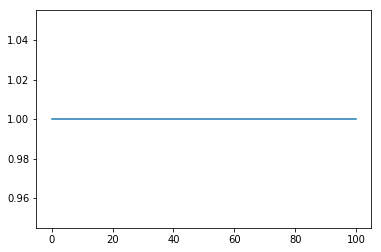

In [42]:
plt.plot(times,ctss)

In [51]:
a = InverseCDFSampler(pdf=ctss,random_state=0)

In [57]:
t_idx=a.sample(100)
t_idx

array([[92.43789532, 25.19347501, 74.49137609, 40.91759553, 31.02591745,
        84.46427294, 65.12142279, 82.95823327, 86.23069046, 48.1248937 ,
        49.46946823, 37.45544935, 11.29699193, 65.75383506,  7.09269952,
        45.43849222, 57.50160843, 51.60571433, 31.96805236, 28.1464263 ,
        63.62833212, 30.83484869, 98.51301871, 77.2481615 , 40.70180299,
        54.33801594, 75.06106008, 62.13733015,  2.67924275, 84.68534099,
        58.84077996, 73.42786054, 59.62285218, 88.02336689, 38.74929252,
        77.2299649 ,  5.81021086, 28.48539581,  3.01193615, 73.95842522,
        65.30709241, 40.92624861, 96.36132028, 10.4804255 , 31.82036525,
        20.37438348, 21.2026068 , 84.84471768, 50.48198953,  5.39874438,
        10.85241081, 98.43040984, 36.22414092, 82.06126166, 35.77506331,
         5.79828978, 23.85296749, 84.42206372,  1.0643908 , 40.33837099,
        11.75203305, 62.30325361, 13.50436339, 73.04908165, 82.37656884,
        78.75412927,  1.96412306, 81.32626062, 47.5

(array([14.,  9.,  7., 11.,  8.,  8., 11., 10., 12., 10.]),
 array([ 0.48670221, 10.28933386, 20.09196551, 29.89459716, 39.69722881,
        49.49986046, 59.30249211, 69.10512376, 78.90775541, 88.71038706,
        98.51301871]),
 <a list of 10 Patch objects>)

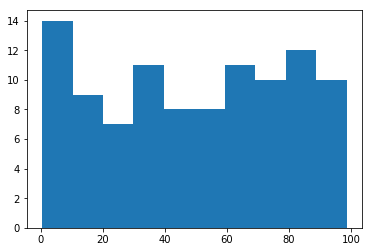

In [58]:
plt.hist(t_idx.squeeze())

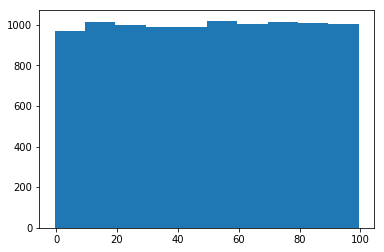

In [50]:
pdf = np.ones(100)
a = InverseCDFSampler(pdf=pdf)
data = a.sample(10000)
plt.hist(data.squeeze());

In [24]:
random_state = get_random_state(0) 
pdf_shape = lc.shape  #gives the shape of the PDF array
pdf = lc.ravel() / lc.sum()  #flattens the array along one axis
sortindex = np.argsort(lc, axis=None) #sorting of the elements and giving the indexes

pdf = pdf[sortindex]  #sort the pdf array
cdf = np.cumsum(pdf)  #evaluate the cumulative sum of the PDF array

AttributeError: 'LightCurveTableModel' object has no attribute 'shape'

In [155]:
choice = random_state.uniform(high=1, size=100)

#find the indices corresponding to this point on the CDF
index = np.searchsorted(cdf, choice)
index = sortindex[index]

# map back to multi-dimensional indexing
index = np.unravel_index(index, pdf_shape) 
index = np.vstack(index)

index = index + random_state.uniform(low=-0.5, high=0.5,
                              size=index.shape)

In [162]:
a = InverseCDFSampler(test,random_state=0)

In [163]:
a = a.sample(100)

In [164]:
np.sort(a)

array([[-4.88285916e-01, -4.81478206e-01, -4.80806802e-01,
        -4.68161070e-01, -4.45662012e-01, -4.41970840e-01,
        -4.30833005e-01, -3.99773113e-01, -3.76180017e-01,
        -3.64525936e-01, -3.50551695e-01, -3.37507065e-01,
        -3.35305844e-01, -3.28370323e-01, -3.13806994e-01,
        -3.00003475e-01, -2.90156251e-01, -2.76918367e-01,
        -2.76075312e-01, -2.72585372e-01, -2.62107179e-01,
        -2.51246856e-01, -2.29992027e-01, -2.09922393e-01,
        -2.02563049e-01, -2.01717674e-01, -1.98425183e-01,
        -1.88055005e-01, -1.54648319e-01, -1.40021936e-01,
        -1.32438130e-01, -1.03494259e-01, -1.01778938e-01,
        -9.28167028e-02, -7.61449514e-02, -7.12312991e-02,
        -6.85815646e-02, -6.41350747e-02, -5.28746214e-02,
        -4.64573173e-02, -9.54119138e-03,  1.32438193e-03,
         2.10366062e-02,  3.56328030e-02,  6.91007386e-02,
         7.22519058e-02,  7.43252488e-02,  7.61573344e-02,
         7.72285886e-02,  8.12728726e-02,  8.99099764e-0

In [64]:
#sampler = MapEventSampler(npred)
#events=sampler.sample_npred()

In [65]:
#events

lon_true,lat_true,e_true
deg,deg,TeV
float64,float64,float64
359.7333370969594,-0.07244496321415028,1.5217603637521027
359.85837797220023,0.20359207355119283,2.1419659842005205
359.8918551765717,-0.019506425432173274,5.622337036174219
359.7953553171566,-0.1186550073707349,1.7314521299420373
0.15735024730484043,0.2935878554699713,1.7356792123034828
359.9989314563643,-0.03092606310887902,1.7304144260407368
0.005488112715788418,-0.06926841577782568,1.206531807265262
359.7997714508275,0.17793342586080713,3.3898717477327427


### Sampling from the PSF

For the testing of the PSF sampling we read in an example PSF from the CTA first data challenge:

In [66]:
filename = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
#filename = "/Users/fabio/LAVORO/CTA/DC/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
psf_gauss = EnergyDependentMultiGaussPSF.read(filename=filename, hdu="POINT SPREAD FUNCTION")
psf_3d = psf_gauss.to_psf3d(rad=np.linspace(0, 1, 100) * u.deg)

From this we create a PSF map:

In [67]:
theta_axis = MapAxis.from_bounds(0, 0.5, nbin=100, unit="deg", name="theta")

geom_psf = WcsGeom.create(
    binsz=0.2,
    skydir=position,
    width="5 deg",
    axes=[theta_axis, energy_axis],
    coordsys="GAL"
)

In [68]:
psf_map = make_psf_map(psf_3d, geom=geom_psf, pointing=geom_psf.center_skydir, max_offset=3 * u.deg)

Now we look up the shape of the PSF at every true event position (in space and energy):

In [69]:
events.sort("e_true")
coord = {
    "lon": events["lon_true"].reshape(-1, 1),
    "lat": events["lat_true"].reshape(-1, 1),
    "energy": events["e_true"].quantity.reshape(-1, 1),
    "theta": (theta_axis.center * theta_axis.unit)
}

pdf = psf_map.psf_map.interp_by_coord(coord)

In [70]:
# plt.figure(figsize=(12, 4))
# plt.imshow(np.sqrt(pdf))
# plt.xlabel("Theta (pixels)")
# plt.ylabel("Event #")

Now we sample form the 2D PDF along the theta axis:

In [71]:
sample_pdf = InverseCDFSampler(pdf, axis=1)
pix_coord = sample_pdf.sample_axis()

offset = theta_axis.pix_to_coord(pix_coord)

In [72]:
random_state = get_random_state(0)
phi_angle = random_state.uniform(360,size=len(events))*u.deg
len(phi_angle), len(events)
event_position = SkyCoord(events['lon_true'], events['lat_true'], frame='icrs', unit='deg')
event_position = event_position.directional_offset_by(phi_angle,offset*u.deg)

In [24]:
#print(event_position.ra * u.deg,event_position.dec * u.deg)

In [25]:
# we apply the psf to the simulated events
#
#events=sampler.apply_edisp(events)

A an additional check we sample from a point source at fixed energy:

In [26]:
N = 100000
energy = np.ones(N) * u.TeV
theta = (theta_axis.center * theta_axis.unit)

coord = {
    "lon": np.zeros(N).reshape(-1, 1),
    "lat": np.zeros(N).reshape(-1, 1),
    "energy": energy.reshape(-1, 1),
    "theta": theta
    
}

pdf = psf_map.psf_map.interp_by_coord(coord)

In [27]:
sample_pdf = InverseCDFSampler(pdf, axis=1)
pix_coord = sample_pdf.sample_axis()
coords = theta_axis.pix_to_coord(pix_coord)

In [28]:
coords

array([0.02267629, 0.03452022, 0.02751198, ..., 0.04107312, 0.02147888,
       0.00921252])

This what the CDF looks like:

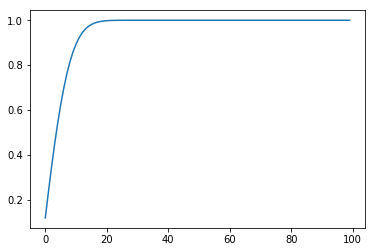

In [29]:
plt.plot(sample_pdf.cdf[0])

Let's check the histogram against the analytical PDF:

(0, 0.2)

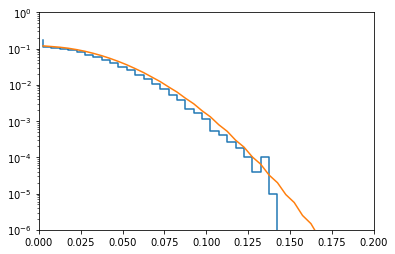

In [30]:
psf_value = psf_3d.evaluate(energy=1 * u.TeV, offset=0 * u.deg, rad=theta)
psf_value = psf_value / psf_value.sum()

psf_hist, vals = np.histogram(coords, theta_axis.edges)
plt.step(theta, psf_hist / psf_hist.sum());
plt.plot(theta, psf_value.squeeze())
plt.semilogy()
plt.ylim(1e-6, 1)
plt.xlim(0, 0.2)

### Sampling from the Edisp

For the testing of the Edisp sampling we read in an example Edisp from the CTA first data challenge:

In [31]:
edisp2D = EnergyDispersion2D.read(filename=filename, hdu="ENERGY DISPERSION")
print(edisp2D)
migra_axis = MapAxis.from_bounds(0, 3, nbin=30, name="migra")

geom = WcsGeom.create(
    skydir=(0, 0), binsz=0.02, width=(5, 5), coordsys="GAL", axes=[migra_axis,energy_axis]
)

EnergyDispersion2D
NDDataArray summary info
e_true         : size =   500, min =  0.005 TeV, max = 495.450 TeV
migra          : size =   300, min =  0.005, max =  2.995
offset         : size =     6, min =  0.500 deg, max =  5.500 deg
Data           : size = 900000, min =  0.000, max = 10595.855



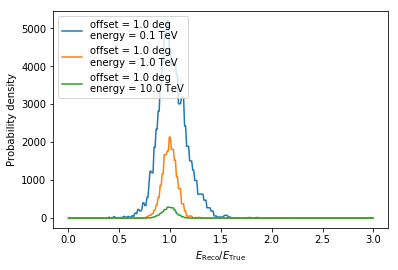

In [32]:
edisp2D.plot_migration()

In [33]:
edisp_map = make_edisp_map(edisp=edisp2D, geom=geom, pointing=geom.center_skydir, max_offset=3 * u.deg)

In [34]:
events.sort("e_true")
coord_edisp = {
    "lon": events["lon_true"].reshape(-1, 1),
    "lat": events["lat_true"].reshape(-1, 1),
    "energy": events["e_true"].quantity.reshape(-1, 1),
    "migra" : (migra_axis.center * migra_axis.unit),
#    "offset": (theta_axis.center * theta_axis.unit)
}

#a=edisp_map.edisp_map
#print(theta_axis)

MapAxis

	name       : theta     
	unit       : 'deg'     
	nbins      : 100       
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 5.0e-01 deg
	interp     : lin       



In [35]:
#a.geom

WcsGeom

	axes       : lon, lat, migra, energy
	shape      : (250, 250, 30, 30)
	ndim       : 4
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 5.0 deg x 5.0 deg deg

In [36]:
pdf_edisp=edisp_map.edisp_map.interp_by_coord(coord_edisp)

In [37]:
sample_pdf_edisp = InverseCDFSampler(pdf_edisp, axis=1)
pix_coord_edisp = sample_pdf_edisp.sample_axis()
coords_edisp = migra_axis.pix_to_coord(pix_coord_edisp)
events['e_true'] * coords_edisp

0.9922251871768986
1.0590193182525132
1.0212708696967578
1.059016746518627
0.9888737524575745
1.0373541449165717
1.046769639410257
1.1685331944546216
1.2491292365435793
1.1124828829247488
1.1686154098055168


In [38]:
#energy = EnergyBounds.equal_log_spacing(0.1,100,100, 'TeV')
#edisp = edisp2D.to_energy_dispersion(offset='0.0 deg', e_reco=energy, e_true=energy)
# use make_edisp_map, migration --> true energies

In [39]:
#np.shape(edisp.data.data)

### Sampling the BKG

For the testing of the background, we read in an example background from the CTA first data challenge:

In [40]:
#bkg = Background3D.read(filename=filename)
#print(bkg)

In [41]:
from gammapy.irf import load_cta_irfs
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
irfs = load_cta_irfs(filename)
print(irfs['bkg'])

Background3D
NDDataArray summary info
energy         : size =    21, min =  0.016 TeV, max = 158.489 TeV
fov_lon        : size =    36, min = -5.833 deg, max =  5.833 deg
fov_lat        : size =    36, min = -5.833 deg, max =  5.833 deg
Data           : size = 27216, min =  0.000 1 / (MeV s sr), max =  0.421 1 / (MeV s sr)



In [42]:
#axis = MapAxis.from_edges(
#    np.logspace(-1.0, 1.0, 30), unit="TeV", name="energy", interp="log"
#)

#energy_axis = MapAxis.from_bounds(1, 100, nbin=30, unit="TeV", name="energy", interp="log")

livetime = 10 * u.hour

geom = WcsGeom.create(
    skydir=(0, 0), binsz=0.02, width=(5, 5), coordsys="GAL", axes=[energy_axis]
)

background = make_map_background_irf(
    pointing=position, ontime=livetime, bkg=irfs["bkg"], geom=geom
)
#make_map_background_irf(pointing=position, ontime=10000, bkg=bkg, geom=geom)

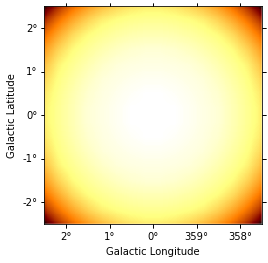

In [43]:
print(background.data)
background.plot_interactive()
#npred = evaluator.compute_npred()

In [44]:
sampler_bkg = MapEventSampler(background)
events_bkg=sampler_bkg.sample_npred()
print(events_bkg)

      lon_true            lat_true            e_true      
        deg                 deg                TeV        
------------------- ------------------- ------------------
 1.4712482274569896 -2.0714340758448695 1.4765230624131571
 0.6075826085921691 -0.1970144690962937  1.958995752606797
 1.3604674002218462  0.9030082585577861   2.17224389630829
 1.8089506770434782   1.095693705280226  1.509324907230878
 0.8519277516944149 -0.9029079039750186  2.235420671302714
  359.9249022999986  0.5171981274115354  1.297699776864798
 0.5070579843982214  1.1602246944960013  1.123918360061966
  359.0898581980895  -2.391201140941377 2.3489223131165886
  359.1737190078381 -1.6264591704502187 1.3042870153048516
 0.5841940177658919 -0.7462074030814401 2.1341575028269855
                ...                 ...                ...
 359.38061808976323  -2.201498109105884 2.3356573058828536
 358.15381860993125   1.767419739661217  1.007846610729335
  358.6484995929584  0.5300665067944198 2.58305279154723

In [45]:
#from gammapy.irf import load_cta_irfs
#filename = (
#    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
#)
#irfs = load_cta_irfs(filename)
#axis = MapAxis.from_edges(
#    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
#)
#geom = WcsGeom.create(
#    skydir=(0, 0), binsz=0.02, width=(5, 4), coordsys="GAL", axes=[axis]
#)
#pointing = SkyCoord(1, 0.5, unit="deg", frame="galactic")
#livetime = 1 * u.hour
#offset_max = 2 * u.deg
#offset = Angle("2 deg")
#background = make_map_background_irf(
#    pointing=pointing, ontime=livetime, bkg=irfs["bkg"], geom=geom
#)

In [46]:
#print(irfs['bkg'])

In [47]:
#bkg = Background3D.read(filename=filename)
#livetime = 10 * u.hour

In [48]:
#print(position)

In [49]:
#bkg.data

In [50]:
#make_map_background_irf(pointing=position, ontime=livetime, bkg=irfs['bkg'], geom=geom)

In [51]:
#print(bkg.)

In [52]:
#make_map_background_irf(pointing=position, ontime=10000, bkg=bkg, geom=exposure)
#make_map_background_irf(pointing=pointing_info, ontime=10000, bkg=bkg, geom=wcs_geom)

In [73]:
sampler = MapEventSampler(npred, psf_map=pdf, edisp_map=pdf_edisp, background_map=background)
events=sampler.sample_npred()
events=sampler.apply_psf(events)
events=sampler.apply_edisp(events)
events_bkg=sampler.sample_background()

In [55]:
len(events),len(events_bkg)

(100, 28024)

In [74]:
sampler = MapEventSampler(npred, psf_map=pdf, edisp_map=pdf_edisp, background_map=background)
events_src_bkg = sampler.sample_events()

In [75]:
events_src_bkg

lon_true,lat_true,e_true
deg,deg,TeV
float64,float64,float64
359.71966813176186,-0.05346579551616161,1.4727317613361146
359.86942713264835,0.2329304925142466,2.199800773604575
359.9131164829808,-0.0002640729443205302,5.4734541904921725
359.788119624894,-0.14238743052670885,1.7249052575327755
0.14291370734333436,0.286141274167102,1.605286857093408
359.9712268634217,-0.027796526866250303,1.6570720797512435
0.017174459545542222,-0.08290654872063291,1.1573103686701585
359.7888948253761,0.22966362286935327,3.5838578045354126


In [11]:
from gammapy.maps import Map, MapAxis
from astropy.coordinates import SkyCoord
from gammapy.spectrum.models import PowerLaw


import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt

spec = np.genfromtxt('/Users/fabio/LAVORO/CTA/Pulsar_e_PWN/HESSJ1825-137_si_S/MAPS/COMPLEX_SIMULATION/spectral_index.txt')

position = SkyCoord(276.200000, -13.966667, frame='icrs', unit='deg')
energy_axis = MapAxis.from_bounds(0.5, 200, 30, interp='log', name='energy', unit='TeV')

# Create a WCS Map
m_wcs = Map.create(binsz=(0.01,0.0006666666666666666), map_type='wcs', skydir=position, width=(3,0.19999999999999998),
                   axes=[energy_axis])


In [12]:
m_wcs.geom.contains_pix

<bound method WcsGeom.contains_pix of WcsGeom

	axes       : lon, lat, energy
	shape      : (300, 300, 30)
	ndim       : 3
	coordsys   : CEL
	projection : CAR
	center     : 276.2 deg, -14.0 deg
	width      : 3.0 x 0.2 deg
>

In [15]:
index = spec[:,2]
flux = spec[:,5] * 1e-13
pos1,pos2 = spec[:,9].astype(int), spec[:,10].astype(int)

fluxunit = 1. / (u.cm ** 2 * u.s * u.TeV)
emin=1 #TeV
emax=5 #TeV
E_ref = 1 #TeV
N0 = flux * (1-index) / (emax**(1-index) - emin**(1-index))


for i in np.arange(len(index)):
    for j in np.arange(len(energy_axis.edges)-1):
        model = PowerLaw(
                     index=index[i],
                     amplitude= N0[i] * fluxunit,
                     reference='1 TeV',
                     )
        flx = model.integral(emin=energy_axis.edges[j],emax=energy_axis.edges[j+1])
        m_wcs.data[j][(300-pos1[i]):(300-pos1[i]+25),pos2[i]:(pos2[i]+25)]=flx


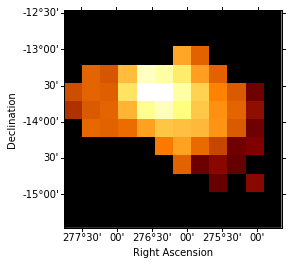

In [16]:
m_wcs.plot_interactive()